# Imports

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

face_cascade = cv2.CascadeClassifier("../assets/haarcascade_frontalface_default.xml")

# Load Images

In [ ]:
images = {
    'train': {},
    'test': {}
}

for type in ['train', 'test']:
    people = [p for p in os.listdir(f'../img/{type}') if os.path.isdir(f'../img/{type}/{p}')]
    for person in people:
        files = os.listdir(f'../img/{type}/{person}')
        for file in files:
            path = f'../img/{type}/{person}/{file}'
            if path.endswith('.jpeg'):
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images[type][person] = images[type].get(person, []) + [img]
                           

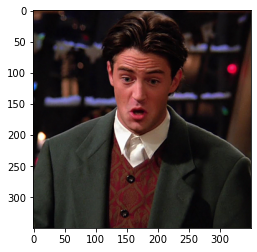

In [ ]:
plt.imshow(images["train"]["ross"][0])

# Convert to gray scale

In [ ]:
images_gray = {
    'train': {},
    'test': {}
}

for k, v in images.items():
    for person, imgs in v.items():
        imgs = [cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in imgs]
        images_gray[k][person] = imgs

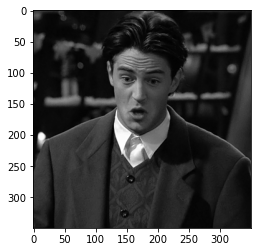

In [ ]:
plt.imshow(images_gray["train"]["ross"][0], cmap="gray")

# Get faces

In [ ]:
faces = {
    'train': {},
    'test': {}
}

for k, v in images_gray.items():
    for person, imgs in v.items():
        imgs = [face_cascade.detectMultiScale(im, 1.3, 5) for im in imgs]
        faces[k][person] = imgs

[[66 69 68 ... 31 30 33]
 [62 64 63 ... 27 26 29]
 [60 61 62 ... 25 23 23]
 ...
 [53 44 38 ... 11 11 11]
 [47 37 36 ... 12 12 12]
 [39 30 29 ... 13 12 12]]


error: OpenCV(4.5.1) ../modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'


In [49]:
faces["train"]["ross"][1][0]

array([[91, 55, 68, 68]], dtype=int32)

In [50]:
def rect(x,y,w,h):
    return [
        [x,x+w,x+w,x,x],
        [y,y,y+h,y+h,y]
    ]

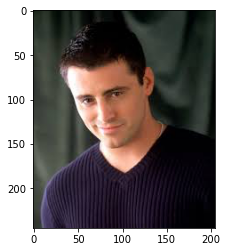

In [52]:
X = []
Y = []
for person, imgs in images["train"].items():
    for i,im in enumerate(imgs):
        try:
            x,y,w,h = faces["train"][person][i][0]
            X.append(im[y:y+h, x:x+w])
            Y.append(person)
        except:
            plt.imshow(im)

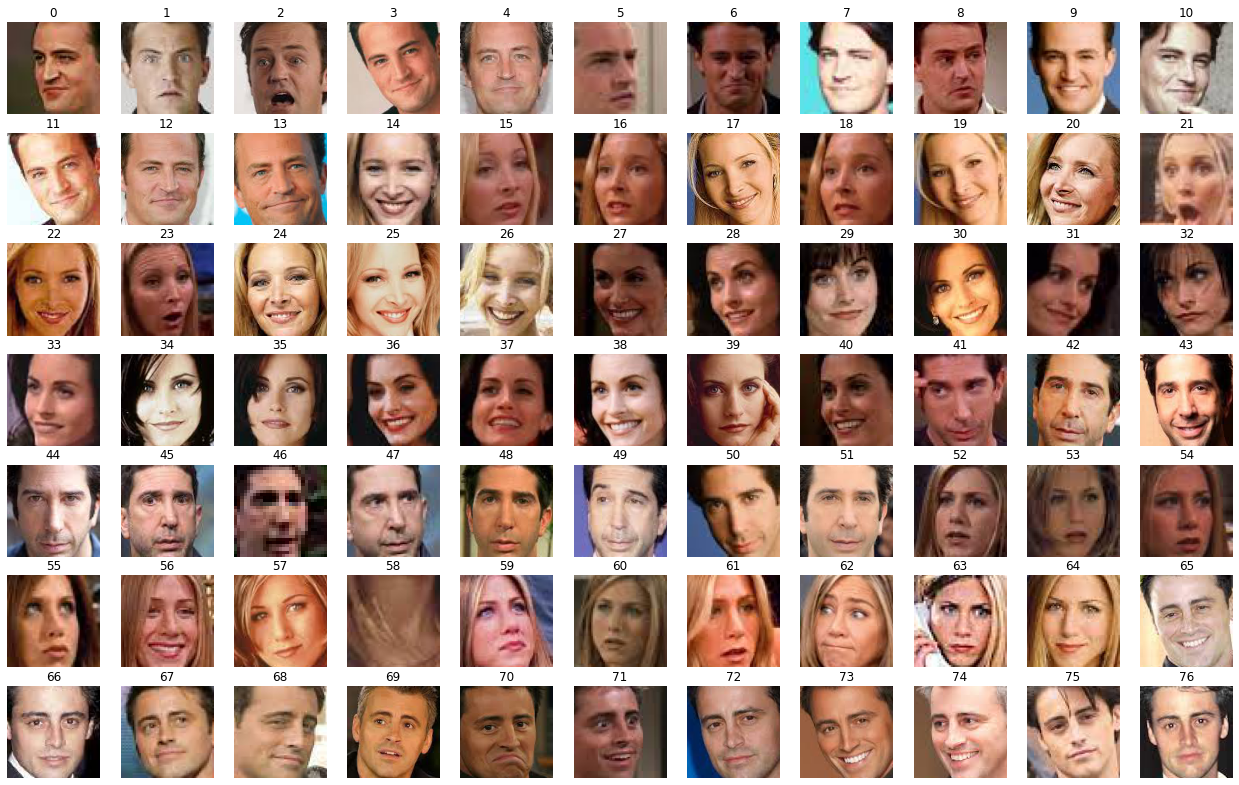

In [53]:
plt.figure(figsize=(22,20))
for i in range(len(X)):
    plt.subplot(10,11,i+1)
    plt.imshow(X[i])
    plt.axis("off")
    plt.title(i)

# Train

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA


In [60]:
len(X)

77

In [61]:
len(Y)

77

In [62]:
knn = KNeighborsClassifier()

X_transformed = []
for img in X:
    im = Image.fromarray(img)
    im = im.resize((64,64))
    X_transformed.append(np.array(im))

In [63]:
X_flat = np.array(X_transformed)
X_flat = X_flat.reshape((77,64*64*3))

In [64]:
knn.fit(X_flat, Y)

KNeighborsClassifier()

In [69]:
def black_and_white(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [70]:
def get_face_coord(img):
    return face_cascade.detectMultiScale(img, 1.3,5)

In [71]:
def get_faces(img):
    gray = black_and_white(img)
    coord = get_face_coord(gray)
    faces = []
    for x,y,w,h in coord:
        faces.append(img[y:y+h,x:x+w])
    return faces

In [72]:
X_test = []
y_test = []
for k,v in images["test"].items():
    for im in v:
        for p in get_faces(im):
            X_test.append(p)
            y_test.append(k)

In [73]:
def predict(model, img):
    img = Image.fromarray(img)
    img = img.resize((64,64))
    img = np.array(img)
    img = img.reshape((1,64*64*3))
    return model.predict(img)

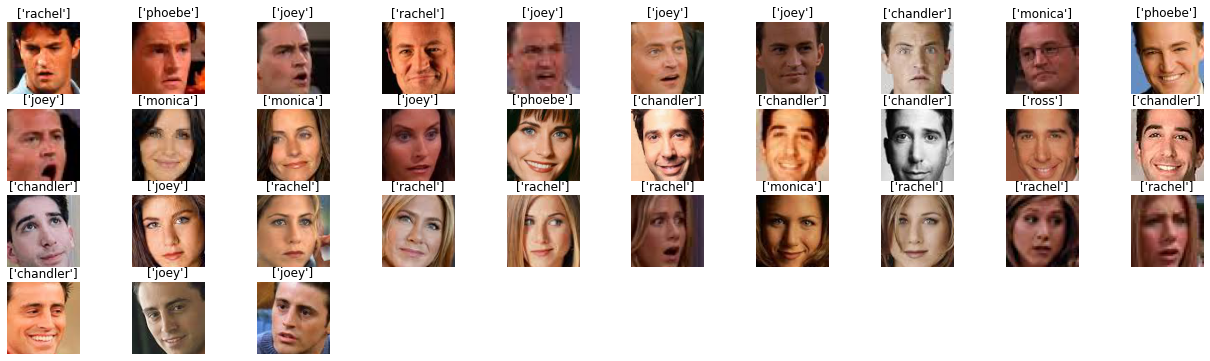

In [74]:
y_pred = []
plt.figure(figsize=(22,22))
for i, face in enumerate(X_test):
    plt.subplot(14,10,i+1)
    plt.imshow(face)
    plt.axis("off")
    y_p = predict(knn,face)
    y_pred.append(y_p)
    plt.title(y_p)

In [75]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.3939393939393939

# Using NN

In [80]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [81]:
ohe = OneHotEncoder()

In [82]:
Y_enc = ohe.fit_transform(np.array(Y).reshape(-1, 1)).todense()

In [83]:
X_nn = np.array(X_transformed)/255

In [84]:
n_classes = len(set(Y))

In [85]:
model = Sequential([
    Conv2D(64, (3,3), activation="relu", input_shape=(64,64,3)),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(256, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Flatten(),
    Dense(512, activation="sigmoid"),
    Dense(n_classes, activation="softmax")
])

2021-10-13 19:25:39.057784: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 19:25:39.060981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 19:25:39.063307: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [87]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [89]:
model.fit(X_nn,Y_enc, epochs=30)

Epoch 1/30
3/3 [==============================] - 0s 142ms/step - loss: 1.0379 - accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 183ms/step - loss: 0.9467 - accuracy: 0.6364
Epoch 3/30
3/3 [==============================] - 0s 152ms/step - loss: 0.8076 - accuracy: 0.7013
Epoch 4/30
3/3 [==============================] - 1s 163ms/step - loss: 0.7143 - accuracy: 0.7273
Epoch 5/30
3/3 [==============================] - 1s 183ms/step - loss: 0.6176 - accuracy: 0.7792
Epoch 6/30
3/3 [==============================] - 0s 131ms/step - loss: 0.4601 - accuracy: 0.8571
Epoch 7/30
3/3 [==============================] - 0s 130ms/step - loss: 0.3365 - accuracy: 0.9221
Epoch 8/30
3/3 [==============================] - 0s 120ms/step - loss: 0.2580 - accuracy: 0.9481
Epoch 9/30
3/3 [==============================] - 0s 134ms/step - loss: 0.2346 - accuracy: 0.8961
Epoch 10/30
3/3 [==============================] - 0s 115ms/step - loss: 0.2188 - accuracy: 0.9481
Epoch 11/30
3/3 [==

In [90]:
ohe.inverse_transform(model.predict(X_nn[:1]))

array([['chandler']], dtype='<U8')

In [91]:
X_test_nn = []

for img in X_test:
    img = Image.fromarray(img).resize((64,64))
    X_test_nn.append(np.array(img)/255)

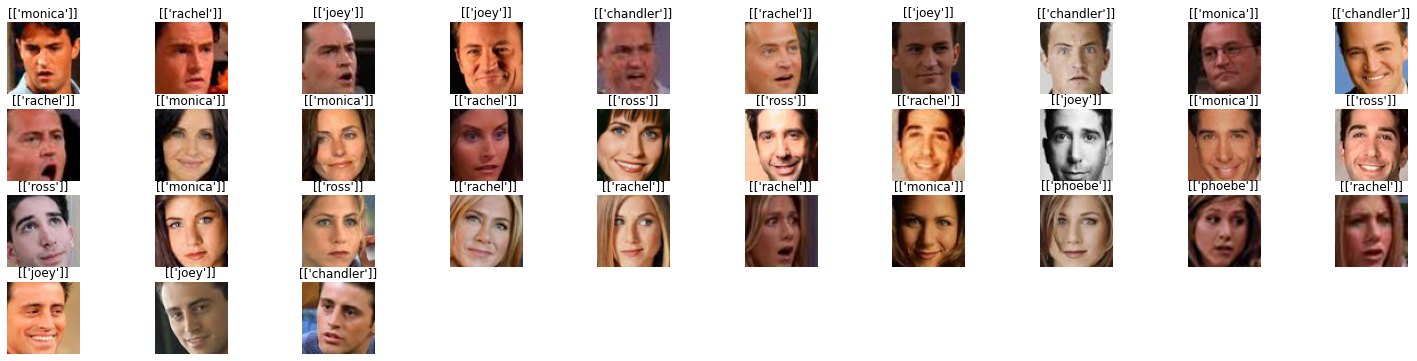

In [92]:
plt.figure(figsize=(26,22))
for i, face in enumerate(X_test_nn):
    plt.subplot(14,10,i+1)
    plt.imshow(face)
    plt.axis("off")
    y_p = ohe.inverse_transform(model.predict(np.array([face])))
    y_pred.append(y_p)
    plt.title(y_p)

In [93]:
from tensorflow.keras.applications import VGG16

In [94]:
X_transformed = []
for img in X:
    im = Image.fromarray(img)
    im = im.resize((224,224))
    X_transformed.append(np.array(im))
X_nn = np.array(X_transformed)/255

X_test_nn = []
for img in X_test:
    img = Image.fromarray(img).resize((224,224))
    X_test_nn.append(np.array(img)/255)
X_test_nn = np.array(X_test_nn)

In [95]:
input_ = VGG16(classes=12,include_top=False, input_shape=[224,224,3])

58892288/58889256 [==============================] - 19s 0us/step


In [96]:
input_.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [97]:
input_.layers[-1].output_shape

(None, 7, 7, 512)

In [98]:
output_ = Sequential([
    Flatten(input_shape=input_.layers[-1].output_shape[1:]),
    Dense(512),
    Dense(n_classes, activation="softmax")
])

In [99]:
model = Sequential([input_,output_])

In [100]:
model.layers[0].trainable=True

In [101]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [102]:
model.fit(X_nn,Y_enc, epochs=30)

Epoch 1/30
3/3 [==============================] - 21s 6s/step - loss: 52.8510 - accuracy: 0.1274
Epoch 2/30
3/3 [==============================] - 23s 7s/step - loss: 7.0964 - accuracy: 0.1456
Epoch 3/30
3/3 [==============================] - 23s 7s/step - loss: 1.8039 - accuracy: 0.1912
Epoch 4/30
3/3 [==============================] - 22s 7s/step - loss: 2.0358 - accuracy: 0.1560
Epoch 5/30
3/3 [==============================] - 22s 6s/step - loss: 2.6255 - accuracy: 0.1274
Epoch 6/30
3/3 [==============================] - 22s 7s/step - loss: 1.7944 - accuracy: 0.1729
Epoch 7/30
3/3 [==============================] - 23s 7s/step - loss: 1.8029 - accuracy: 0.2315
Epoch 8/30
3/3 [==============================] - 22s 7s/step - loss: 1.7826 - accuracy: 0.2354
Epoch 9/30
3/3 [==============================] - 22s 6s/step - loss: 1.7922 - accuracy: 0.1768
Epoch 10/30
3/3 [==============================] - 21s 6s/step - loss: 1.7937 - accuracy: 0.1925
Epoch 11/30
3/3 [=====================

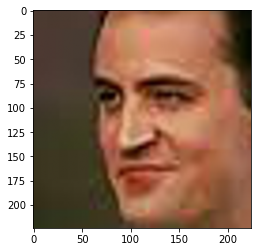

In [103]:
plt.imshow(X_nn[0])

In [104]:
ohe.inverse_transform(model.predict(X_nn[0:1]))

array([['chandler']], dtype='<U8')

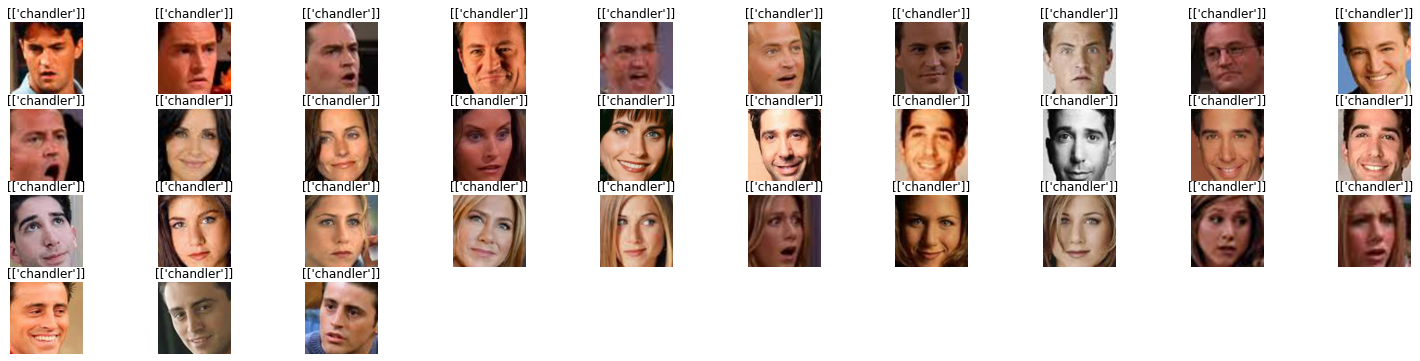

In [105]:
y_pred=[]
plt.figure(figsize=(26,22))
for i, face in enumerate(X_test_nn):
    plt.subplot(14,10,i+1)
    plt.imshow(face)
    plt.axis("off")
    y_p = ohe.inverse_transform(model.predict(np.array([face])))
    y_pred.append(y_p)
    plt.title(y_p)